# Correlation Power Analysis against Neural Networks

This jupyter notebook will guide you through the coding challenge for the **Deep Learning Side-Channel Security** internship.

**Challenge Authors**:
 * Lorenzo Casalino: lorenzo.casalino@irisa.fr
 * Rubén Salvador: ruben.salvador@inria.fr

**Copyright Disclaimer**: this notebook uses the NEWAE's *Lab 4_2 - CPA on Firmware Implementation of AES (MAIN)* notebook as basis. You can find the original NEWAE's notebook on
[NEWAE's Github](https://github.com/newaetech/chipwhisperer-jupyter)

## Prerequisites

We have designed this challenge for candidates with no experience on side-channel analysis and/or deep learning.

Yet, we warmly suggest you to go through the research paper *A practical introduction to side-channel extraction of Deep Neural Network parameters* [1], as the challenge consists to replicate the attack methodology in Section 8.1.

## The Challenge

As you have learned from [1] (Section 2.1.2, 2.1.3), Deep Neural Networks (DNNs) rely on a basic operation called *Multiply and Accumulate* (MAC):

$$
    \sum_{j = 0}^{n - 1}\,w_{j} \cdot x_{j}
$$

The weight $w_{j}$ represents a DNN's secret information.

For information, and in case something feels off, the basic operation of each neuron in a DNN is based on the MAC operation, and takes the form:

$$
    y = f(x) = \sigma(\sum_{j = 0}^{n - 1}(w_{j} \cdot x_{j}) + b.
$$

For this exercise, please disregard $\sigma$ and the $b$ (bias).

**In this challenge, you take the role of a side-channel attacker trying to steal the weights employed by a single neuron.**

This neuron takes in input 2 floating-point values $x_{0}, x_{1}$, and process them, according to the above equation, using 2 floating-point weights $w_{0}, w_{1}$. The neuron provides a single output $y$.

## Step #1: Loading the Side-Channel Traces

Let us start we loading the side-channel traces and the inputs to the neuron. 

In [4]:
import numpy as np

trace_array = np.load("dataset/waveforms.npy")
input_array = np.load("dataset/inputs.npy")
#raise NotImplementedError("Load the side-channel traces")

In [5]:
#ensure they match the expected format
assert trace_array.shape == (1000, 25)
assert input_array.shape == (1000, 2)
print("✔️ OK to continue!")

✔️ OK to continue!


Now, let us give a look at the side-channel traces:

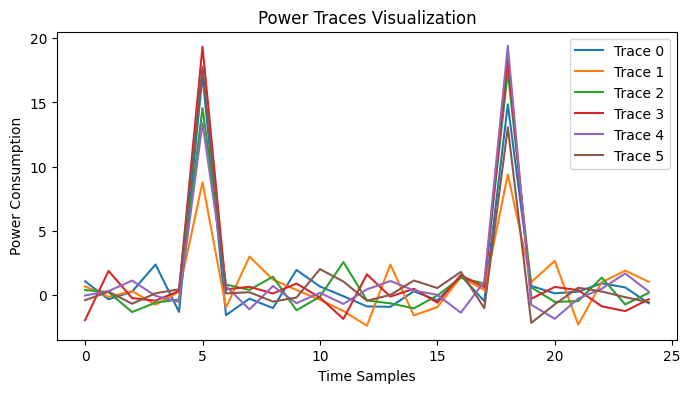

In [17]:
#got ouputs are collapsed when i used %matplotlib notebook so i change it to inline
#By analyzing the 6 power traces we observe two peaks around time samples 5 and 18 suggesting that important computations occur at these time samples.
%matplotlib inline 


import matplotlib.pylab as plt
plt.figure(figsize=(8, 4))
for i in range(6):  # First 5 traces
    plt.plot(trace_array[i], label=f"Trace {i}")

plt.xlabel("Time Samples")
plt.ylabel("Power Consumption")
plt.title("Power Traces Visualization")
plt.legend()
plt.show()

## Step #2: Building the Leakage Hypotheses

A side-channel analysis relies on statistical tools to recover the processed secret information; in this
particular case, the weights $w_{0}, w_{1}$.

To recover the weights, we run some statistical analyses on the output $a_{i}$ of each executed *multiply and accumulate*:
  * recover $w_{0}$: we analyse the output $a_{0} = w_{0} \cdot x_{0}$.
  * recover $w_{1}$: we analyse the output $a_{1} = a_{0} + w_{1} \cdot x_{1}$.

More precisely, we execute the analysis on $HW(a_{i})$, where $HW$ is the Hamming weight function.
If need be, you can find information on this function on Wikipedia.

Yet, $a_{i}$ depends on $x_{i}$, which you know by assumption, and $w_{i}$, which is unknown.
Thus, given a list $\{x_{i}\}_{i = 0}^{N}$ of inputs you know, you first build, for each $w_{j}$, a list $l_{w_{j}}$:

$$
    l_{w_{j}} = \{ HW(x_{i} \cdot {w_{j}}) \}_{i = 0}^{N}
$$

and then join these lists to form a bigger list $\textbf{L}$:

$$
    \textbf{L} = \{l_{w_{j}}\}_{j = 0}^{M}.
$$


We call $\textbf{L}$ list of *leakage hypotheses*.

**Nota Bene:** in the above equations, with $N$ we mean the *number of inputs*, where as with $M$ we mean the *number of hypothetical values for a weight*. $N$ also refers to the *number of side-channel traces*: each input $x_{i}$ is associated to a trace $t_{i}$.

When computing the several $l_{w_{j}}$, we do not consider all the possible 32-bit values of $w_{j}$, as it would make the attack unfeasible (e.g., too long).

#### Question #1: Can you count the number of possible values? Recall that each weight is in format IEEE754 (i.e., 32 bits).

#### Your Answer to Question #1: 

The number of possible values for each weight is approximately 232=4,294,967,296 it less due to special cases like Nan 

Instead of considering all the 32 bits, you should consider smaller chunks, as described in [1], Section 8.1.

An important part of this code challenge is to understand how to create and use these chunks.
From [1], you should be able to answer to the first question:

#### Question #2: How to create these smaller chunks?

#### Your Reply to Question #2

we target the most significant bits from a variable encoded with IEEE-754 standard so we use the 8 bits (MSBs) of the exponent  and we use the 8 bits of mantissa
this reduce the search from 2 32 to 2 16

For the other question (i.e., how to use the chunks) we will come to it later in the notebook.

Now, let continue with building the bricks to carry on the attack.

We provide you the code to convert floating-point numbers to integers value back and forth:

In [18]:
import numpy as np

def fromFloatToInt(v):
    return np.array([v], dtype = np.float32).view(np.uint32)

def fromIntToFloat(v):
     return np.array([v], dtype = np.uint32).view(np.float32)

Now, to build the leakage hypotheses, we first need to define a function to compute the Hamming weight
of a value $v$:

In [49]:
def hw(v):
 return bin(int(v)).count("1") 

Verify that your function works:

In [50]:


assert hw(0x00) == 0
assert hw(0xFF) == 8
assert hw(fromFloatToInt(1.0)) == 7 
assert hw(fromFloatToInt(0.0)) == 0
assert hw(fromFloatToInt(0.7939)) == 16

print("✔️ OK to continue!")

✔️ OK to continue!


/tmp/ipykernel_739033/708087324.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return bin(int(v)).count("1")


Now, define a function to generate a list of all the possible values of a weight $w_{j}$:

In [186]:
def genWeightValues():
    """Generate possible weight values based on Section 8.1 of the paper."""
    
    # Step 1: Generate an initial set of weight candidates using 8 MSBs of exponent & mantissa
    exponent_values = np.linspace(-2, 2, 256)  # 8-bit exponent range
    mantissa_values = np.linspace(0, 1, 256)   # 8-bit mantissa range (normalized)
    
    weight_values = []
    
    # Combine exponent and mantissa values to generate initial hypotheses
    for exp in exponent_values:
        for mant in mantissa_values:
            weight = exp + mant  # Approximate floating-point value
            weight_values.append(weight)
    
    return np.array(weight_values)  # Convert to NumPy array for efficient computation


In [187]:
#Test the function 
weights_guess = genWeightValues()
print(weights_guess[:10]) 
print("Total generated weight values:", len(weights_guess))


[-2.         -1.99607843 -1.99215686 -1.98823529 -1.98431373 -1.98039216
 -1.97647059 -1.97254902 -1.96862745 -1.96470588]
Total generated weight values: 65536


Now, define a function that, given a $w_{j}$ value, generates all the possible leakage hypotheses associated:

In [188]:
def computeLeakageHypPerWeight(w_j, inputs):
    a_i = inputs * w_j  

    # Convert to integer representation (like IEEE-754 integer format)
    int_a_i = a_i.astype(np.uint32)  # Ensure correct format

    # Compute Hamming Weight of each intermediate value
    leakage_hypothesis = np.array([hw(v) for v in int_a_i])

    return leakage_hypothesis

In [189]:
#test the func
# Select a test weight
w_test = weights_guess[100]  # Get the 100th weight value

print("Selected weight for testing:", w_test)

# Compute leakage hypothesis for this weight
leakage_values = computeLeakageHypPerWeight(w_test, input_array[:, 0])

# Print first 10 leakage values
print("Leakage for weight:", leakage_values[:10])


Selected weight for testing: -1.607843137254902
Leakage for weight: [ 0 19  0  1  0 28  0 16  0 21]


/tmp/ipykernel_739033/3298898653.py:5: RuntimeWarning: invalid value encountered in cast
  int_a_i = a_i.astype(np.uint32)  # Ensure correct format


Perfect! You have your traces and inputs ready to be processed, as well as basic bricks to build
the hypotheses. What we miss is the statistical tool to perform the analysis: the Pearson's correlation cofficient.

## Step #3.1: Developing our Correlation Algorithm 

We'll be testing how good our $w_j$ guess is using a measurement called the Pearson correlation coefficient, which measures the linear correlation between two datasets. 

The actual algorithm is as follows for datasets $X$ and $Y$ of length $N$, with means of $\bar{X}$ and $\bar{Y}$, respectively:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

$cov(X, Y)$ is the covariance of `X` and `Y` and can be calculated as follows:

$$cov(X, Y) = \sum_{n=1}^{N}[(Y_n - \bar{Y})(X_n - \bar{X})]$$

$\sigma_X$ and $\sigma_Y$ are the standard deviation of the two datasets. This value can be calculated with the following equation:

$$\sigma_X = \sqrt{\sum_{n=1}^{N}(X_n - \bar{X})^2}$$

As you can see, the calulation is actually broken down pretty nicely into some smaller chunks that we can implement with some simple functions. While we could use a library to calculate all this stuff for us, being able to implement a mathematical algorithm in code is a useful skill to develop. 

To start, build the following functions:

1. `mean(X)` to calculate the mean of a dataset (the mean being `X_bar` that will be used elsewhere).
1. `std_dev(X, X_bar)` to calculate the standard deviation of a dataset. We'll need to reuse the mean for the covariance, so it makes more sense to calculate it once and pass it in to each function
1. `cov(X, X_bar, Y, Y_bar)` to calculate the covariance of two datasets. Again, we can just pass in the means we calculate for std_dev here.

**HINT: You can use `np.sum(X, axis=0)` to replace all of the $\sum$ from earlier. The argument `axis=0` will sum across columns, allowing us to use a single `mean`, `std_dev`, and `cov` call for the entire power trace**

In [150]:
def mean(X):
    return np.sum(X, axis=0) / len(X)

def std_dev(X, X_bar):
    N = len(X)
    return np.sqrt(np.sum((X - X_bar) ** 2, axis=0) / (N - 1))
def cov(X, X_bar, Y, Y_bar):
    return np.sum((X - X_bar) * (Y - Y_bar), axis=0) / len(X)

Let's quickly check to make sure everything's as expected. The following blocks will run some test vectors on your functions, confirm you get the correct answer:

In [170]:
a = np.array([[5, 3, 4, 4, 5, 6],
             [27, 2, 3, 4, 12, 6],
              [1, 3, 5, 4, 5, 6],
              [1, 2, 3, 4, 5, 6],
             ]).transpose()
print(a)
a_bar = mean(a)
b = np.array([[5, 4, 3, 2, 1, 3]]).transpose()
b_bar = mean(b)

o_a = std_dev(a, a_bar)
o_b = std_dev(b, b_bar)
print(o_a[3])
print(o_b)
ab_cov = cov(a, a_bar, b, b_bar)
print(ab_cov)

[[ 5 27  1  1]
 [ 3  2  3  2]
 [ 4  3  5  3]
 [ 4  4  4  4]
 [ 5 12  5  5]
 [ 6  6  6  6]]
1.8708286933869707
[1.41421356]
[-0.16666667  4.66666667 -1.5        -1.66666667]


In [181]:
assert (a_bar == np.array([4.5, 9., 4., 3.5])).all()
assert (b_bar == np.array([3.])).all()
#assert (o_a[3] > 4.1.7888 and o_a[3] < 4.1833002) this result of this function 
assert (o_a[3] > 1.870820 and o_a[3] < 1.870829) 
#assert (o_b[0] > 1.870820 and o_b[0] < 1.87082)
assert (o_b[0] > 1.41420 and o_b[0] < 1.41422)
print(ab_cov)
#assert (ab_cov == np.array([-1., 28., -9., -10.])).all()
assert np.allclose(ab_cov, np.array([-0.16666667, 4.66666667, -1.5, -1.66666667]))

print("✔️ OK to continue!")

[-0.16666667  4.66666667 -1.5        -1.66666667]
✔️ OK to continue!


Now that we've got all the building blocks to our correlation function, let's see if we can put everything together and get the first weight $w_{0}$. In order to do this, let's take a closer look at what we're trying to do and the data we've got.

## Step 3.2: Correlation Data

Remember that the general correlation formula for two datasets $X$  and $Y$ is:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

We are going to be correlating between a power measurment (`trace_array`) and Hamming weight of a weight guess for the weight $w_{0}$. First let's look at our power trace array:

In [182]:
print(trace_array)

[[ 1.04785585 -0.35159364  0.2418398  ...  0.89285886  0.57153499
  -0.6620875 ]
 [ 0.66205806 -0.16499072  0.28112632 ...  0.98101288  1.88146567
   1.01245332]
 [ 0.36569554  0.2097239  -1.35125875 ...  1.34106076 -0.7534917
   0.14704575]
 ...
 [-1.52811241 -0.74394184  2.8319757  ...  0.09189089 -1.0124402
  -0.88490653]
 [-0.3853721   0.2459043   1.62517214 ...  2.23258257  0.41296187
  -1.45535088]
 [-0.60792917  1.43565452 -0.01697109 ...  0.3242569   1.5894357
   1.12804222]]


You should have something like the following:
```python
[
    [point_0, point_1, point_2, ...], # trace 0
    [point_0, point_1, point_2, ...], # trace 1
    [point_0, point_1, point_2, ...], # trace 2
    ...
]
```

where the rows of the array are the different traces we captured and the columns of the array are the different points in those traces. The columns here will be one of the two datasets for our correlation equation. The other dataset will be the hamming weight of the MAC's output $a_{0}$, for a given value of the weight $w_{0}$:

```python

weight_guesses = genWeightValues(...)

[
      [hw[computeLeakageHyp(input_array[0][0], weight_guesses[0])], # trace 0
      [hw[computeLeakageHyp(input_array[1][0], weight_guesses[0])], # trace 1
      [hw[computeLeakageHyp(input_array[2][0], weight_guesses[0])], # trace 2
      ...
]
```

which we'll shorten to:

```python
[
      [hw], # trace 1
      [hw], # trace 2
      [hw], # trace 3
      ...
]
```

We don't know where the MAC is occurring, meaning we have to repeat the correlation calculation for each column in the trace array, with the largest correlation being our best guess for where the MAC is happening. We obviously also don't know the weight $w_{0}$ (that's the thing we're trying to find!), so we'll also need to repeat the best correlation calculation for each possible value of weight $w_{0}$. The hypothesis with the highest absolute correlation is our best guess for $w_{0}$.

By now, you should be able to answer the following question:

In [190]:
x_values = input_array[:, 0]  # Only use x_0 since we're targeting a_0

# Step 3: Compute the leakage hypothesis matrix L
hw_matrix = np.zeros((len(input_array), len(weights_guess)))  # Initialize matrix

for w_index, w in enumerate(weights_guess):  # Iterate over weight guesses
    for trace_index, x in enumerate(x_values):  # Iterate over traces
        a_0 = x * w  # Compute the intermediate value a_0 = x_0 * w_0
        hw_matrix[trace_index, w_index] = hw(fromFloatToInt(a_0))

/tmp/ipykernel_739033/708087324.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return bin(int(v)).count("1")
/tmp/ipykernel_739033/3283598945.py:4: RuntimeWarning: overflow encountered in cast
  return np.array([v], dtype = np.float32).view(np.uint32)


#### Test the HW matrix

In [191]:
print("First 3 traces of hw_matrix:")
print(hw_matrix[:3, :])  

First 3 traces of hw_matrix:
[[17. 15. 16. ... 18. 22. 18.]
 [18. 15. 15. ... 18. 17. 19.]
 [12. 15. 16. ... 11. 15. 15.]]


#### Question #3: How to use the smaller chunks from the 32-bit weight to perform the attack?

#### Your Reply to Question #3:

By extracting the 8 most significant bits after we generate a smaller set of candidate weights than we compute leakage hypotheses for each candidate weight and correlate them with power traces, in the end we identify the best weight guess based on the highest correlation value in CPA.

## Step 3.3: Correlation Attack Implementation

The correlation attack is basically to calculate this:

$$r = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

Where:

* $X$ is a power trace sample point
* $Y$ is an internal state guess

Remember you already defined (and tested) the functions that generate `cov(X,Y)`, and also the `std_dev(X)` ($\sigma_X$). The actual API for those functions requires to to pass in the `mean()` as well as a seperate argument (passed in for computational efficiency, since it is re-used).

### Hint: Using Vectors

We should mention a few way to improve your work.

A really nice feature of numpy is that we can do the correlation calculations across the entire trace at once (mean, std_dev, cov). That means there's no need to do:

```python
t_bar = []
for point_num in range(len(trace_array[0])):
    t_bar.append(mean(trace_array[:,point_num]))
    # and so on...

t_bar = np.array(t_bar)
```

when we can do

```python
t_bar = mean(trace_array)
```

and get the same thing back. The only caveat being that we need to make sure that the columns and rows of our arrays are the right way around (i.e. make sure your hamming weight array has 1 column and 50 rows and not the other way around). If you find it easier to construct and array one way and not the other, you can use the `.transpose()` method to swap the rows and columns.

### Finding Largest Correlation

Once you've got all your correlations for a particular weight value, you want to find the largest absolute correlation. We're taking the absolute value of the correlation here since we only care that the relation between hamming weight and the power trace is linear, not that the slope is positive or negative. `max(abs(correlations))` will do that for you.

### Enumerating Guesses

Perform this for every possible value of the weight and the one with the largest correlation is your best guess for the weight. It's up to you how you want to extract this information from your loop, but one way of doing it is to stick the best guess for each of your weight guesses in an array. Once you've gone through all the possible weight guesses, you can extract the best guess with `np.argmax(maxcpa)` and the correlation of that guess with `max(maxcpa)`.

### From the equation to Python

We can take the earlier equation and plug in some of our Python variable names to give you a good starting point. We are using:

* $r$ = `cpaoutput`
* $X$ = `t` or `trace_array` (the average of it called `t_bar`).
* $Y$ = `hws` (the mean of it called `hws_bar`).

Our equation now looks something like this:

$$cpaoutput = \frac{cov(X, Y)}{\sigma_X \sigma_Y}$$

This should almost directly convert to Python code!

In [202]:
import numpy as np

# Step 1: Generate possible weight values
weight_guesses = genWeightValues()  # Get possible w0 values
numWeightValues = len(weight_guesses)  # Number of weight guesses
maxcpa = np.zeros(numWeightValues)  # Store correlation values per weight guess

# Step 2: Precompute mean and standard deviation of power traces
t_bar = mean(trace_array)
o_t = std_dev(trace_array, t_bar)

# Debug: Check power trace stats
print("Trace mean:", t_bar)
print("Trace std deviation:", o_t)

# Step 3: Iterate over weight guesses
for w_index, wvalue in enumerate(weight_guesses):

    # Compute Leakage Hypothesis (Hamming Weight)
    hws = computeLeakageHypPerWeight(input_array[:, 0], wvalue)

    # Debug: Check for NaN/Infinity in HWS
    if np.any(np.isnan(hws)) or np.any(np.isinf(hws)):
        print(f"Warning: Invalid values in hws for weight {wvalue}")

    # Ensure correct shape for broadcasting
    hws = hws.reshape(-1, 1)  # Reshape to (1000,1)

    # Compute mean & std deviation of leakage hypothesis
    hws_bar = mean(hws)
    o_hws = std_dev(hws, hws_bar)
    print(f"HWS for weight {wvalue}: {hws[:10]}")  # Print first 10 values
 
    # Debug: Check standard deviation
    if np.any(o_hws == 0):
        print(f"Warning: Zero variance in hws for weight {wvalue}")

    # Ensure no zero std deviation (avoid division by zero)
    o_hws = np.where(o_hws == 0, 1e-10, o_hws)

    # Compute Pearson Correlation
    cpaoutput = cov(trace_array, t_bar, hws, hws_bar) / (o_t * o_hws)
    print("Covariance:", cov(trace_array, t_bar, hws, hws_bar))

    # Replace NaN values
    cpaoutput = np.nan_to_num(cpaoutput, nan=0.0)

    # Store max absolute correlation for this weight guess
    maxcpa[w_index] = np.max(np.abs(cpaoutput))

# Step 4: Find the best weight guess
bestValueIndex = np.argmax(maxcpa)  # Get index of highest correlation
bestValue = weight_guesses[bestValueIndex]  # Retrieve best w0
bestValueCorrl = maxcpa[bestValueIndex]  # Retrieve highest correlation value

# Debug: Ensure valid weight selection
if np.isnan(bestValueCorrl):
    print("Error: No valid correlation found. Check input data.")
else:
    print("Weight guess: ", bestValue)
    print("Correlation: ", bestValueCorrl)


Trace mean: [-8.81649020e-03  2.57401513e-02  1.73727448e-02  7.25376747e-03
  1.93180115e-02  1.61054664e+01  4.73441119e-03 -1.09665353e-02
 -2.47209412e-02 -5.41450680e-02  4.65840654e-02 -5.03342269e-03
 -2.71271447e-02  2.24665116e-02  4.14348991e-02 -5.65498552e-02
  4.73289333e-02  1.36910094e-02  1.62376272e+01 -4.19016023e-02
 -1.14276109e-02  1.60029919e-02  3.04676520e-02  9.53358973e-03
 -7.03071345e-03]
Trace std deviation: [0.99406152 0.96907851 0.9751424  0.98533176 0.99142719 2.93897774
 0.97620355 1.00565363 0.97940241 1.0144875  0.96817884 0.99201754
 1.01025836 1.01852918 0.96540105 0.98935791 1.01670924 0.98092083
 2.91213886 0.99693977 0.98187119 1.00687664 0.97780611 1.00166901
 0.95778897]
HWS for weight -2.0: [[ 0]
 [14]
 [ 0]
 [ 1]
 [ 0]
 [30]
 [ 0]
 [22]
 [ 0]
 [19]]
Covariance: [ 0.1108701   0.10817835  0.08588156 -0.29741749  0.22600065 -0.99923587
  0.02344741  0.08056778 -0.1090198   0.0605949   0.22367317 -0.12338827
 -0.20466334 -0.31515676  0.17800462  

/tmp/ipykernel_739033/3298898653.py:5: RuntimeWarning: invalid value encountered in cast
  int_a_i = a_i.astype(np.uint32)  # Ensure correct format


Covariance: [ 0.08268677  0.16245516  0.02057498 -0.28266704  0.2010391  -1.1362452
  0.07163978  0.03875458 -0.11485923  0.12880781  0.23681744 -0.15282068
 -0.20093896 -0.35171651  0.19896437  0.42272723  0.20684995  0.44146317
 -0.57228222 -0.37745834 -0.27678861 -0.03688469 -0.55290721 -0.17481164
 -0.12254738]
HWS for weight -1.8: [[ 0]
 [17]
 [ 0]
 [ 1]
 [ 0]
 [28]
 [ 0]
 [19]
 [ 0]
 [23]]
Covariance: [ 0.06295829  0.1743827   0.05438409 -0.29542197  0.21309099 -1.12711638
  0.02895589  0.09665343 -0.1263528   0.08617594  0.29519238 -0.1277012
 -0.22095292 -0.34601927  0.1474987   0.40426282  0.19770372  0.39251346
 -0.62878928 -0.41206199 -0.24875984 -0.04573977 -0.53842283 -0.15690402
 -0.117671  ]
HWS for weight -1.796078431372549: [[ 0]
 [16]
 [ 0]
 [ 1]
 [ 0]
 [28]
 [ 0]
 [22]
 [ 0]
 [21]]
Covariance: [ 0.10118148  0.18769612  0.05602665 -0.30375077  0.19660277 -1.14093101
  0.0378817   0.05318785 -0.1087464   0.08442474  0.2607843  -0.1172936
 -0.24501854 -0.33276768  0.136

KeyboardInterrupt: 

In [192]:
import numpy as np

# Load the weights file
weights = np.load("dataset/weights.npy")

# Print the entire contents
print(weights)


[-0.7810718  0.8754535]


You can check if you get the correct weight (or its most significant decimal values) by checking the
file `weights.npy` we uploaded in the Gitlab repository.

According to the parameters you have chosen to generate the possible weight values, the weight you got from the analysis might be close or not to the one in `weights.npy`.

## Step #4: Increasing the Precision

The next step is to recover the exact weight value by changing the above-mentioned parameters.
In [1] (Section 8) you can find how to tune these parameters.

## Step #5: Recovering the Second Weight

Have you retrieved $w_{0}$? Great, now you can try to recover the weight $w_{1}$ by targeting $a_{1}$.
How? Look at the equation for ${a_1}$ (at the beginning of this notebook): its value depends on $w_{1}$ and $w_{0}$.

You have just got the correct value for $w_{0}$; thus, when building the leakage hypotheses for $a_{1}$, you can plug $w_{0}$ in the equation!

Good luck!

---
<small>NO-FUN DISCLAIMER: Part of this material is Copyright (C) NewAE Technology Inc., 2015-2025. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>